<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

# Load libraries

In [1]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
import seaborn as sns
#sns.set()

from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE

import tensorflow as tf
import tarfile

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=a56264314d501e5153477fdecc82b30fdf7d3cd1229824ed01ac933ecaef0e6c
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=45c2fb85ca5863c8a0cbc4d7d6d2b889905bd9ea28c5ad503c3716b3963cc82e
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
import umap

In [ ]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

261349/261349 [==============================] - 0s 0us/step


In [ ]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [ ]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

In [ ]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')
plt.show()

In [ ]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [3]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [4]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)

    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)

    return features_scaled

In [5]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


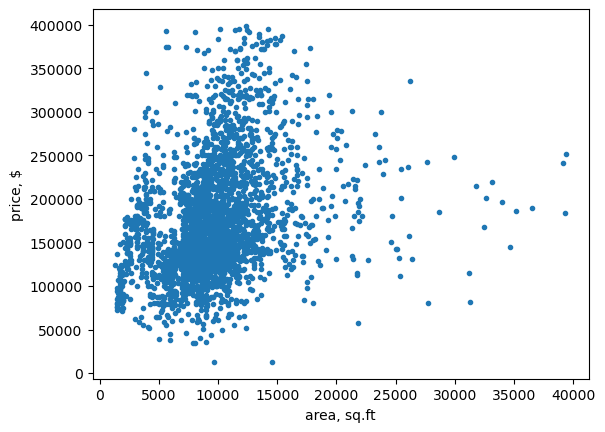

In [6]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

# 1. Unsupervised Learning Techniques


Unsupervised learning technique different from supervised ones from the fact that data are not labelled (no supervision).

We do not aim at fitting a mapping from $X$ to $Y$, but to understand pattern in the data cloud $X$.

## 1. Principal Component Analysis (PCA)

Let's start with the example that we will use to make the theory more concrete. We will take a dataset from from kaggle https://www.kaggle.com/datasets/miroslavsabo/young-people-survey?resource=download (already downloaded for you in the folder `data`)

The datasets consists of the results of a survey about the music preferences of several students, arriving at the following dataset:

In [ ]:
data=pd.read_csv("data/responses.csv")

In [ ]:
data

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5.0,2.0,5.0,2.0,2.0,5.0,4.0,4.0,4.0,3.0,...,20.0,164.0,57.0,1.0,female,right handed,secondary school,no,city,house/bungalow
1006,4.0,4.0,5.0,1.0,3.0,4.0,1.0,4.0,1.0,1.0,...,27.0,183.0,80.0,5.0,male,left handed,masters degree,no,village,house/bungalow
1007,4.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,...,18.0,173.0,75.0,0.0,female,right handed,secondary school,yes,city,block of flats
1008,5.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,4.0,1.0,...,25.0,173.0,58.0,1.0,female,right handed,college/bachelor degree,no,city,block of flats


In [ ]:
music_columns=data.columns[:19]
print(music_columns)
music_data=data[music_columns].dropna()

Index(['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country',
       'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
       'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll',
       'Alternative', 'Latino', 'Techno, Trance', 'Opera'],
      dtype='object')


The answers are of course correlated and we expect to have typical patterns recurring, that we define as people liking similar types of songs.

The patterns may be also mixing, for e.g. a class of people may like classic `Pop` and `Reggae`, but not `Latino`. An other class may like `Latino` and `Reggae`, but not `Pop`.

PCA will help to find these typical patterns and their number in a data driven fashion. As we will see these patterns will naturally appear when trying to compress data in a lower dimensional space.

### Theory overview.

We will look at PCA from the point of view of `dimensionaliy reduction`.

**Objective:** PCA is used for dimensionality reduction when we have a large number $D$ of features with non-trivial intercorrelation ( data redundancy ) and to isolate relevant features. The number of features $D$ defines the original dimension of the dataset. Each sample defines a vector of dimensionality $D$.


    QUESTION: what are the starting vectors in our survey dataset? How many do we have?

PCA provides a new set of $M$ uncorrelated features for every data point, with $M \le D$. The new features are:

- a linear combination of the original ones ;
- uncorrelated between each other ;

If $M \ll D$ we get an effective dimensionality reduction.

    QUESTION: Does the number of data points changes after applying PCA?

***MOTIVATION***

What do we need from a dimensionality reduction?

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-theory.png" width="100%"/>

***REPRESENTATION***

Each data point indexed by $p=1..N$ starts from an original $D-$dimensional space:
$$x_p=(x_{p,1},...,x_{p,D})$$

We want to find another more economical representation with $M$ components:
$$x'_p=(x_{p,1},...,x_{p,M})$$

PCA does that by defining $D$ auxiliar vectors, called the `principal components` or `principal vectors`:

$$k_1=(k_{1,1},...,k_{1,D})$$
$$...$$
$$k_D=(k_{D,1},...,k_{D,D})$$

$$\mathbf k_{i'} \cdot \mathbf k_{j'} = \delta_{i',j'}$$

such that:

$$x'_{p,i'}=\mathbf x_p \cdot \mathbf k_{i'}, i'=1...D$$

How are these principal components chosen? How can prove that:

$$S^2=\frac{1}{N}\sum_{p=1}^{N}  |\mathbf{x}_p - \mathbf{\overline{x}}|^2=\sum_{i'=1}^{D}\left( \frac{1}{N}\sum_{p=1}^{N}  |x_{p,i'} - \overline{x'}_{i'}|^2\right) $$  
and therefore:

$$S^2=\epsilon_1+\epsilon_2+...+\epsilon_D$$

PCA finds principal vectors $\mathbf k$ such that $\epsilon_1$ is as largest as possible, $\epsilon_2<\epsilon_1$ is such that $\epsilon_1+\epsilon_2$ is as largest as possible, and so on. Therefore truncating the summation the error is as small as possible among all possible choices all $k$-vectors. The $\epsilon$ are called the `explained variance` values.

The ratios:

$$\rho_1=\epsilon_1/S^2,\rho_2=\epsilon_2/S^2,...$$

are called the `explained variance ratio` values, and their cumulated brothers:

$$r_1=\epsilon_1/S^2,r_2=(\epsilon_1+\epsilon_2)/S^2,...,r_D=1$$

is the `cumulated explained variance ratio`.

The number of components is chosen selecting an optimal number of components (M) to keep. The plot of the explained variance ratio as a function of k is called a *scree plot* as serves to select an optimal value of $M$ (if it exists). If $M$ is small we have obtained a new data representation.

NAMES TO REMEMBER:

- `Principal components`: A sequence of orthonormal vectors $k_1,..,k_n$. We can interpret these vectors as the typical patterns found in the data, from increasing to decreasing probability of appearance.

- `Scores`: For every sample-point $p$, the new features are called scores are given by the component of $p$ along the $k$ vectors: $$x'_{p,i}=\mathbf x_p \cdot \mathbf k_i$$, sometimes also denoted with the letter $s_{p,i}$.  

- `Explained variance`: For every k, the ratio between the variance of the reconstructed vectors and total variance. The number of components is chosen selecting an optimal k. The plot of the explained variance as a function of k is called a *scree plot*.



***INTERPRETATION: RECONSTRUCTED VECTOR***

The scores can be used to derive a best approximation of the original vector, if needed, using only the first $M$ principal components:

$$\mathbf x_{rec}=\sum_{i=1}^M s_{p,i} \mathbf k_i$$

When doing this operation, PCA acts like a filter to remove noise. This also explains the interpretation of the principal component as a pattern.

    QUESTION:
    What are the main differences between a vector $x_p$ and a principal component $k_n$? In particular:
    1) how many do we have ?
    2) what are their dimensions ?
    
    QUESTION:
    What are the differences between $x_p$ and a score vector $s_p$? In particular:
    1) how many do we have ?
    2) what are their dimensions ?
    
    QUESTION:
    1) How many reconstructed vectors do we have? What is their dimension ? Can we have a reconstructed vector with zero error?

### Sklearn: implementation and usage of PCA.


https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

We start showing a two-dimensional example that can be easy visualized.

We load the datasets that we are going to use for the examples:

In [ ]:
data=load_sample_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')
plt.show()

The data set is almost one dimensional. PCA will confirm this result.

As with most of sklearn functionalities, we need first to create a PCA object. We will use the object methods to perform PCA.

In [ ]:
pca=PCA(n_components=2)

A call to the pca.fit method computes the principal components

In [ ]:
pca.fit(data)

PCA(n_components=2)

Now the pca.components_ attribute contains the principal components. We can print them alongside with the data and check that they constitute an orthonormal basis.

In [ ]:
plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

circle=plt.Circle((0, 0), 1.0, linestyle='--', color='red',fill=False)
ax=plt.gca()
ax.add_artist(circle)

for vec in pca.components_:
    plt.quiver([0], [0], [vec[0]], [vec[1]], angles='xy', scale_units='xy', scale=1)

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

The pca.explained_variance_ratio_ attribute contains the explained variance. In this case we see that already the first reconstructed vector explains 95% of the variance.

In [ ]:
print(pca.explained_variance_ratio_)

[0.95140729 0.04859271]


To compute the reconstructed vectors for k=1 we first need to compute the scores and then multiply by the basis vectors:

$$\mathbf x_{rec}=\sum_{i<M} (\mathbf x \cdot \mathbf k_i) \mathbf k_i$$

In [ ]:
k=1
scores=pca.transform(data)
res=np.dot(scores[:,:k], pca.components_[:k,:] )

In [ ]:
plt.figure(figsize=((5,5)))
plt.plot(res[:,0],res[:,1],'o')
plt.plot(data[:,0],data[:,1],'o')

for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
    plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

plt.grid()

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

The same procedure is followed for high dimensional datasets. Here we generate random data which lies almost on a 6-dimensional subspace. The resulting scree plot can be used to find this result in a semi-automatic fashion.

Let's redo the same now with our survey dataset, to review the concepts again and think "high"-dimensionally.

In [ ]:
pca=PCA()
pca.fit(music_data)

PCA()

In [ ]:
plt.plot(pca.explained_variance_ratio_,'-o')

In [ ]:
df = pd.DataFrame(pca.components_.transpose(),
                  columns = [f'V_{i+1}' for i in range(len(music_columns))],
                  index=music_columns)
df

In [ ]:
for vector in ['V_1','V_2','V_3','V_4']:
    plt.figure()
    plt.title(vector)
    plt.plot(np.arange(len(music_columns)),list(df[vector]),'-o')
    _=plt.xticks(np.arange(len(music_columns)),music_columns, rotation=90)
    plt.grid()

### EXERCISE 1 : Find the dimensionality of the hidden dataset.

In [ ]:
# In this exercise you will take a custom high dimensional dataset and try to find its dimensionality.

# STORY: you suppose you have 20 sensors measuring blood pressure in different parts of the bad during the day,
# reporting measurments every second.
#
# We assume that some particular movements of the body will produce a correlated response in blood pressure.
# Furthermore, these body movements do not happen independently but are superposing each other,
#so that the final pressure measured is a sum of all of them.
#
# You are given a dataset of recording. Your task is to use PCA to discover, under these assumptions,
# how many are the body movements producing these resposes, and to characterize the blood pressure response along these 20 sensors.

# To do that:

# 1. Load the data using the function data=load_multidimensional_data_pca() , check the dimensionality of the data and plot them.
data=...
n_samples,n_dim=...
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca....

# 3. Check the explained variance ratio and select best number of components. How many are the typical body movements?
print(pca...)
plt.plot(...)

# 3. Plot the pattern response associated to the typical body movements by exploring the principal vectors.
for vec in pca.components_[:...]:
    ...

### EXERCISE 2 : Find the hidden drawing.

In [ ]:
### In this exercise you will take a high dimensional dataset, find the optimal number of principal components
# and see what plot do we get if we visualize in a 2D plot the first two scores.

#
## STORY: there is a man of a parallel universe where strings generated a very high dimensional space
#instead of our 3D one. He wants to communicate with you making a drawing that you can access as a set of
#points in a multidimensional letter, given to you as a numpy array. The guy tried to do hist best to communicate
#with you. He cannot write in a 2D space, but he can write on a 2-D subspace of this multidimensional one.
#Mathematically he can link in a subspace generated by the multidimensional vectors k1 and k2, such a subspace
#is the subset of points s1 * k_1 + s_2 * k_2 .

# Can you decode the message?
#

# 1. Load the data using the function data=load_ex2_data_pca(seed=1235) , check the dimensionality of the data to
#get a feeling of how high dimensional this letter is.
data=...
n_samples,n_dim=...
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca....

# 3. Check the explained variance ratio and select best number of components. Did the guy do a good job?
print(pca...)
plt.plot(...)

# 4. Try to plot the first score against the second one, for each of the data point. What does the alien want to tell you?
k=...
data_transformed=...
plt.plot(data_transformed[:,...],data_transformed[:,...],'o')
plt.xlabel('First component')
plt.ylabel('Second component')

### EXERCISE 3 (bonus) :

In [ ]:
# Explore more the survey dataset. Suppose you have studied the first vectors and found
# some 4 types of music advertisment, targetted to the 4 classes of clients.

# Given a customer, how would you choose which advertisement to send him?

### Final comments:

PCA is able therefore to make this mapping:

$(x_1,...,x_D) \rightarrow (y_1,..,y_M)$

Here we focused on data compression, but it is also very important that $y_1,...,y_M$ are uncorrolated for interpratibility purposes. Being uncorrelated means (roughly) that in our dataset we can change one variable without affecting the others. The dimensions 1,...,M are often therefore more interpretable and providing more information.

See e.g. a similar application here:

"Principal component analysis of dietary and lifestyle patterns in relation to risk of subtypes of esophageal and gastric cancer", https://pubmed.ncbi.nlm.nih.gov/21435900/

, where each data point $x$ is an answer from a questionnaire of food. The principal components are than typical "patterns" of answers that are uncorrlated, have a look at table 2, and if you want read the whole data story :)

## 2. Data visualization and embedding in low dimensions ( t-SNE / UMAP )

### Theory overview

PCA is a linear embedding technique where the scores are a linear function of the original variables. This forces the number of principal components to be used to be high, if the manifold is highly non-linear. Curved manifolds need to be embedded in higher dimensions.

Other `non-linear` embedding techniques start from a local description of the environment of each sample point in the original space:

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` describes the `topology` of the environment through a generalized "triangulation" (simplex decomposition) ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment.

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf



Instead, the following, we will show how to apply practically these dimensionality reductions techniques. Keep in mind that the embedding is given by an iterative solution of a minimization problem and therefore the results may depend on the value of the random seed, especially for t-SNE visualizazions.

### Utilization in Python and examples

To begin with, we create a t-SNE object that we are going to use.

In [ ]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
                      n_iter=2000, random_state=2233212, metric='euclidean', verbose=100 )

umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

### Example 1: Exercise 3 Cont'd

We will first visualize our multi-dimensional heart using t-SNE:

In [ ]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
                      n_iter=300, random_state=2233212, metric='euclidean', verbose=1 )

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.001s...
[t-SNE] Computed neighbors for 651 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.060286


/home/arismarcolongo/miniconda3/envs/selective_search/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.369261
[t-SNE] KL divergence after 300 iterations: 0.602112


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from utils.routines import *
import matplotlib.pyplot as plt

X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3, verbose=1).fit_transform(X)
X_embedded.shape

[t-SNE] Computing 3 nearest neighbors...
[t-SNE] Indexed 4 samples in 0.000s...
[t-SNE] Computed neighbors for 4 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 4 / 4
[t-SNE] Mean sigma: 12.094863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.738800
[t-SNE] KL divergence after 1000 iterations: 0.047805


(4, 2)

In [ ]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=1)

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.001s...
[t-SNE] Computed neighbors for 651 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.025506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.112373
[t-SNE] KL divergence after 1000 iterations: 0.924472


In [ ]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])
plt.show()

And using UMAP :

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

umap_hart = umap_model.fit_transform(data)
plt.scatter(umap_hart[:, 0], umap_hart[:, 1])
plt.show()

### Example 2: Mnist dataset

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca',
#                   n_iter=2000, random_state=2233212,
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

In [ ]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)
plt.show()

### Example 3: Fashion_Mnist dataset

In [2]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=50, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
#                      n_iter=1000, random_state=2233212, metric='euclidean', verbose=100 )

# tsne_fmnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_fmnist[:,0],tsne_fmnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_fmnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/fmnist.png" width="100%"/>
 |  -----:| -----:|

/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


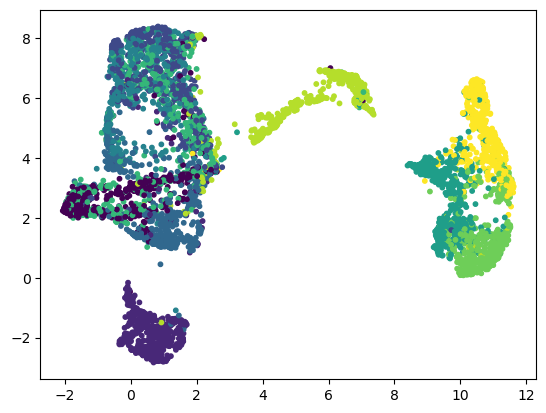

In [6]:
umap_model = umap.UMAP(n_neighbors=50, n_components=2, random_state=1711)
umap_fmnist = umap_model.fit_transform(data)
plt.scatter(umap_fmnist[:, 0], umap_fmnist[:, 1], c=labels, s=10)
plt.show()

### Example 4: House prices

In [68]:
data=house_prices_dataset_normed()
x, y, df = house_prices_dataset(return_df=True, price_max=-1, area_max=-1)

In [ ]:
# not to run on COLAB

#tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200,
#                  early_exaggeration=4.0,init='pca', n_iter=1000,
#                  random_state=2233212, metric='euclidean', verbose=100)

#tsne_houses = tsne_model.fit_transform(data)

#plt.scatter(tsne_houses[:,0],tsne_houses[:,1],s=20)
#plt.savefig('t_sne_houses.png')
# plt.show()

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_houses.png" width="50%"/>

/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


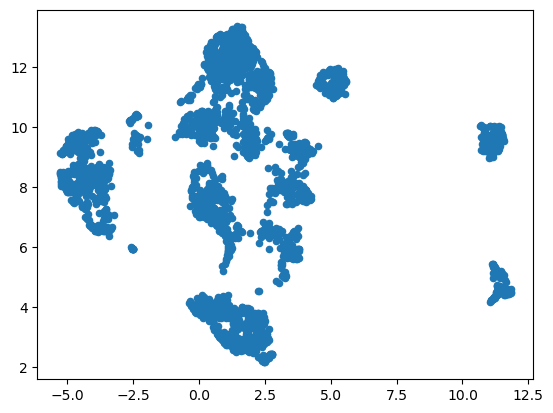

In [69]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

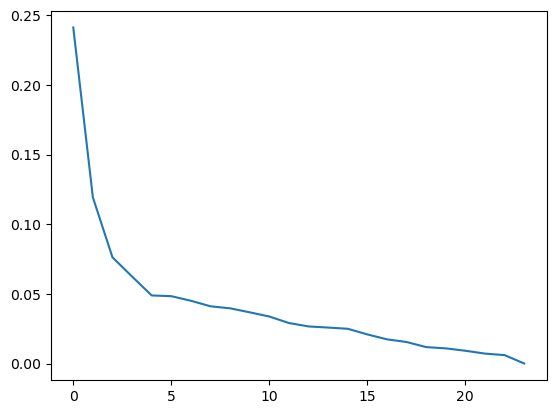

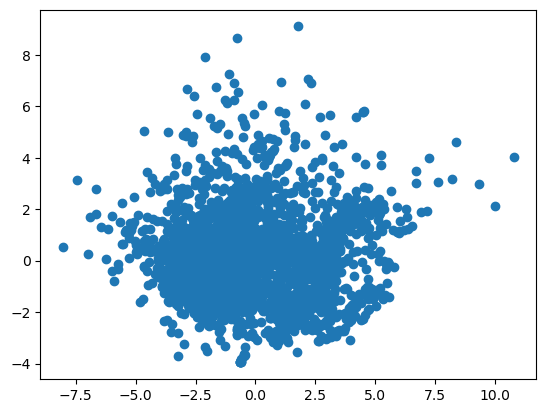

In [70]:
pca=PCA()
pca.fit(data)
plt.plot(pca.explained_variance_ratio_)
plt.figure()
scores=pca.fit_transform(data)
plt.plot(scores[:,0], scores[:,1],'o')

In [ ]:
def plot_umap(column):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(umap_houses[:, 0], umap_houses[:, 1], c=df[column], cmap='viridis', s=20)
    plt.colorbar(scatter)
    plt.title(f'Scatter plot colored by {column}')
    
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

for c in df.columns:
    plot_umap(c)

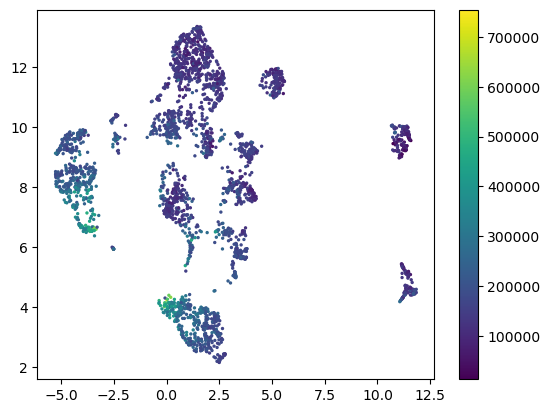

In [72]:
scatter = plt.scatter(umap_houses[:, 0], umap_houses[:, 1], c=y, cmap='viridis', s=2)
plt.colorbar(scatter)

In [74]:
import hdbscan

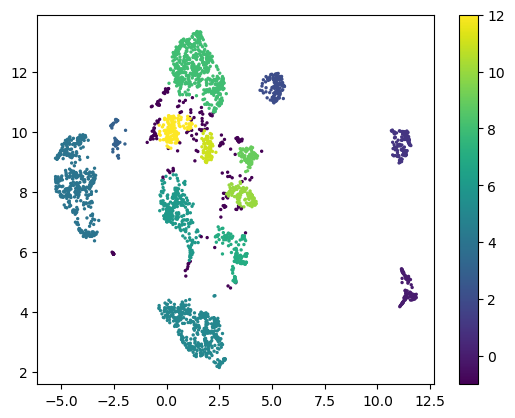

In [75]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, gen_min_span_tree=True)
clusterer.fit(umap_houses)

scatter = plt.scatter(umap_houses[:, 0], umap_houses[:, 1], c=clusterer.labels_, cmap='viridis', s=2)
plt.colorbar(scatter)

labels=clusterer.labels_
classes=set(labels)-set([-1])

#for c in classes:
#    mask=labels==c
#    plt.figure()
#    plt.title(c)
#    plt.xlim(-6,15)
#    plt.ylim(1,15)
#    scatter = plt.scatter(umap_houses[mask][:, 0], umap_houses[mask][:, 1],  s=2)


In [77]:
# Convert data to a pandas DataFrame (for easier column selection)

useful_fields = ['LotArea',
                'Utilities', 'OverallQual', 'OverallCond',
                'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                'HeatingQC', 'CentralAir', 'Electrical',
                '1stFlrSF', '2ndFlrSF','GrLivArea',
                'FullBath', 'HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                'Functional','PoolArea',
                'YrSold', 'MoSold'
                ]
df = pd.DataFrame(data, columns=useful_fields)
df['cluster']=clusterer.labels_

df_2=df[df['cluster']!=-1]
df_2=df_2.sort_values(by='cluster')

(2197, 24)
Accuracy: 0.9981818181818182
Confusion Matrix:
[[528   0]
 [  1  21]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       528
           1       1.00      0.95      0.98        22

    accuracy                           1.00       550
   macro avg       1.00      0.98      0.99       550
weighted avg       1.00      1.00      1.00       550

(2197, 24)
Accuracy: 0.9763636363636363
Confusion Matrix:
[[512   1]
 [ 12  25]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       513
           1       0.96      0.68      0.79        37

    accuracy                           0.98       550
   macro avg       0.97      0.84      0.89       550
weighted avg       0.98      0.98      0.97       550

(2197, 24)
Accuracy: 0.9763636363636363
Confusion Matrix:
[[524   0]
 [ 13  13]]
Classification Report:
              precision    recall 

/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

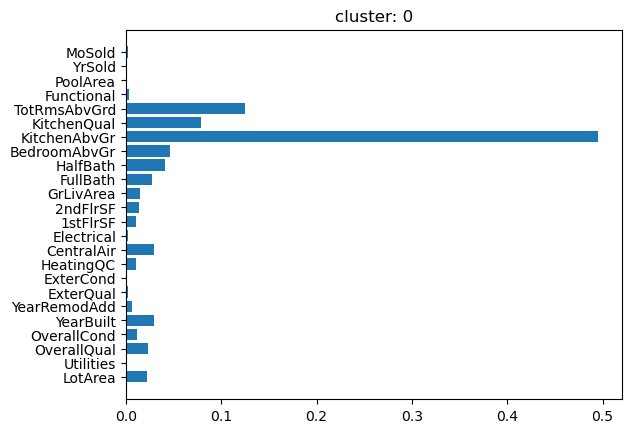

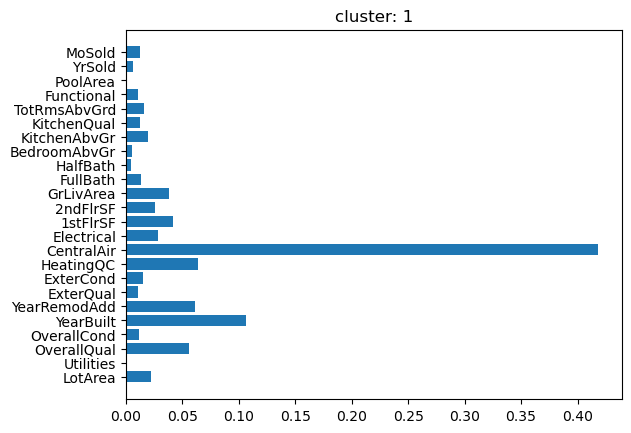

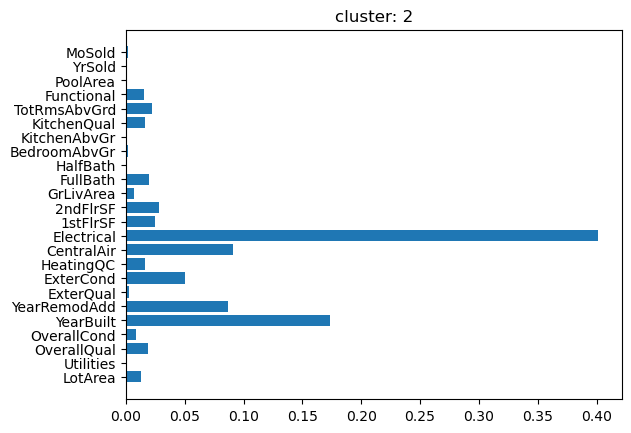

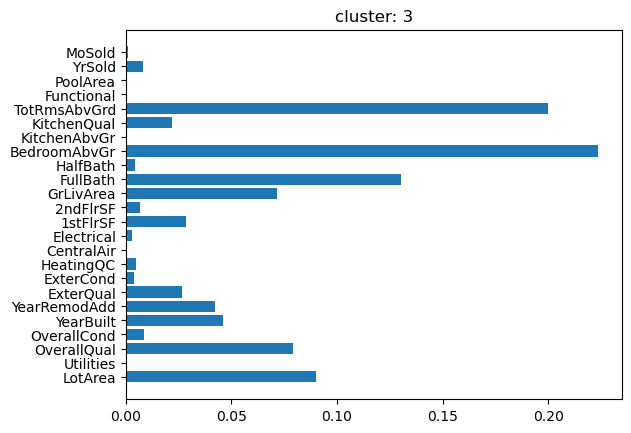

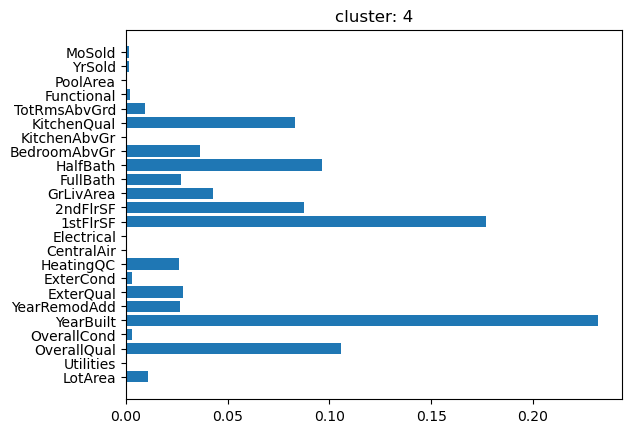

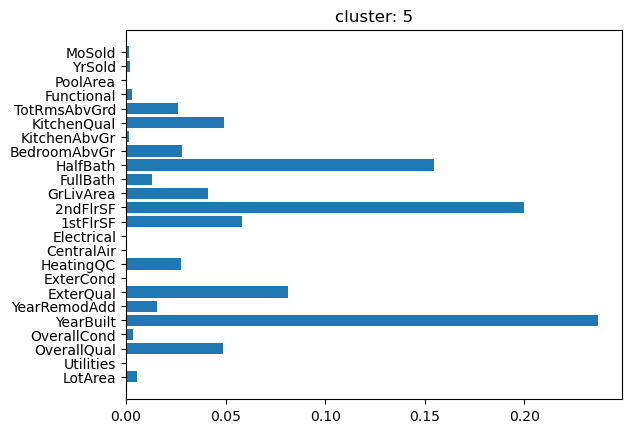

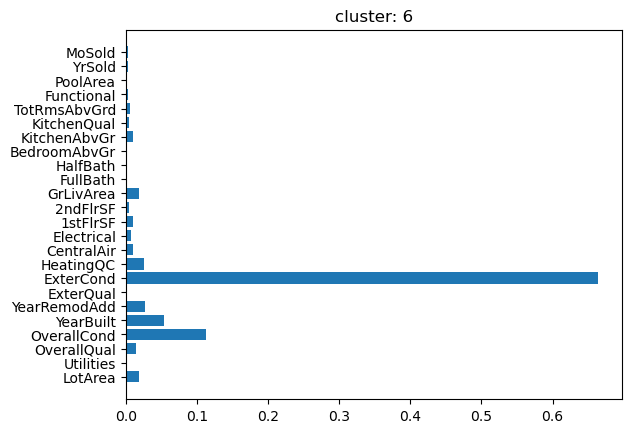

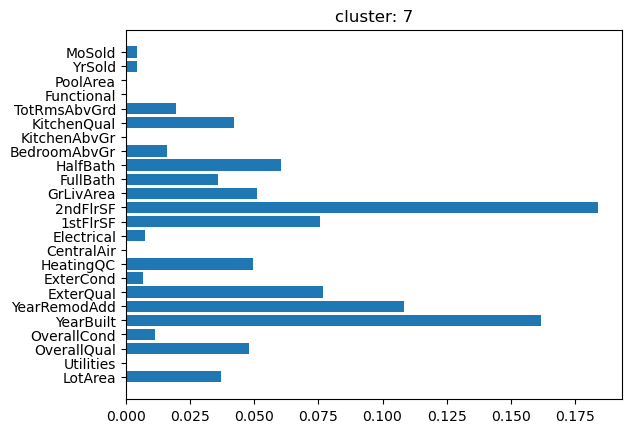

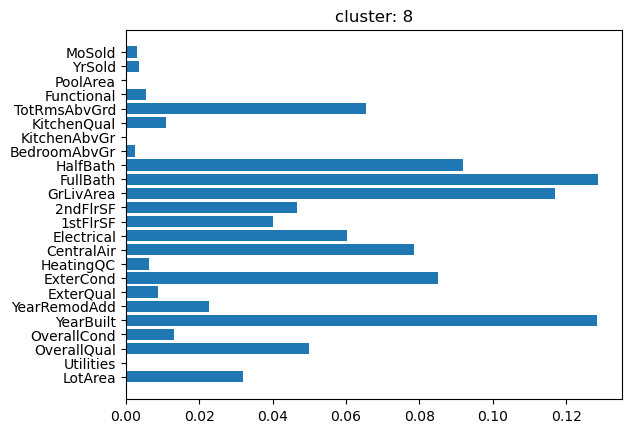

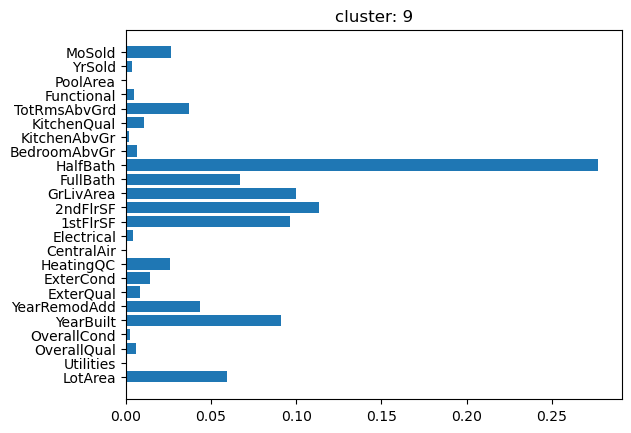

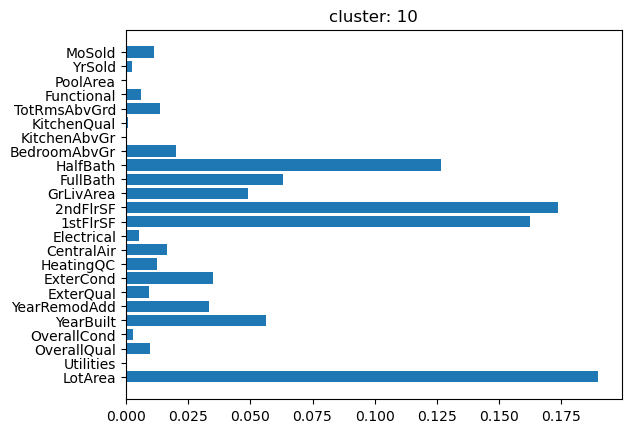

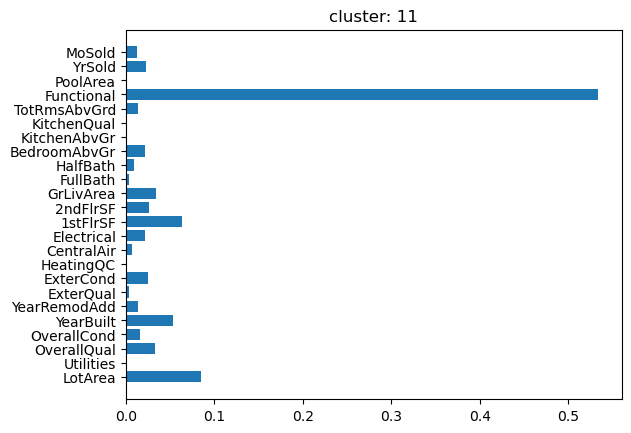

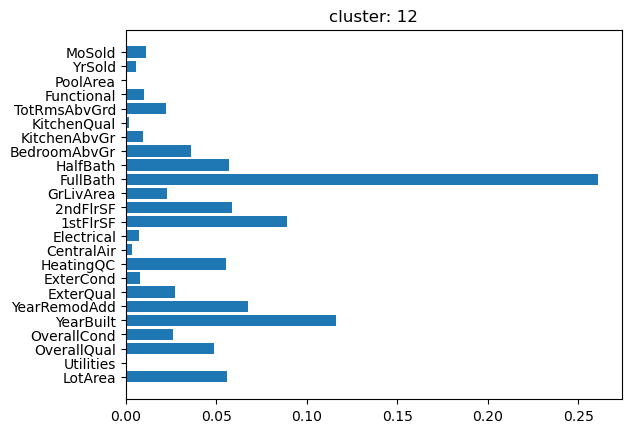

In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming your dataframe is df, and 'cluster' is the target column
# Separate features and target

for cluster in range(13):

        X = df_2.drop('cluster', axis=1)  # Features
        y = df_2['cluster']               # Target (Cluster column)

        y = [1 if i==cluster else 0 for i in y]

        # Split the data into training and testing sets (80% train, 20% test)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(X_train.shape)

        # Initialize the Random Forest Classifier
        rf_model_2 = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)

        # Train the model
        rf_model_2.fit(X_train, y_train)

        # Predict on the test set
        y_pred = rf_model_2.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)

        # Print evaluation metrics
        print(f"Accuracy: {accuracy}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)

        plt.figure()
        plt.barh(useful_fields,
                rf_model_2.feature_importances_)
        plt.title(f'cluster: {cluster}')

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming your dataframe is df, and 'cluster' is the target column
# Separate features and target
X = df_2.drop('cluster', axis=1)  # Features
y = df_2['cluster']               # Target (Cluster column)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

(2197, 24)
Accuracy: 0.8654545454545455
Confusion Matrix:
[[ 20   0   0   0   0   1   0   0   1   0   0   0   0]
 [  1  34   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0  25   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   5  11   2   0   0   1   0   0   0   0]
 [  0   0   0   0  84   1   0   0   0   0   0   0   0]
 [  0   0   0   0   1  85   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0  48   0   0   0   0   0   0]
 [  0   0   0   0   0   3   0  26   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0 117   0   0   0   0]
 [  0   0   0   0   1   0   0   0  15   0   0   0   0]
 [  0   0   0   0   0   0   0   2   3   0  18   0   0]
 [  1   0   0   0   1   1   2   0   3   0   0   5   0]
 [  2   0   0   0   2   0   0   0  13   0   0   0   9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       1.00      0.92      0.96        37
           2       1.00      0.96      0

/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [96]:
def plot_importances(feature_names, permutation_importances):
    plt.figure(figsize=(8, 10))
    plt.barh(feature_names,
            permutation_importances.importances_mean,
            yerr=permutation_importances.importances_std, )
    plt.ylabel('feature')
    plt.xlabel('importance')
    plt.xlim(0, 0.2)
    return 

<BarContainer object of 24 artists>

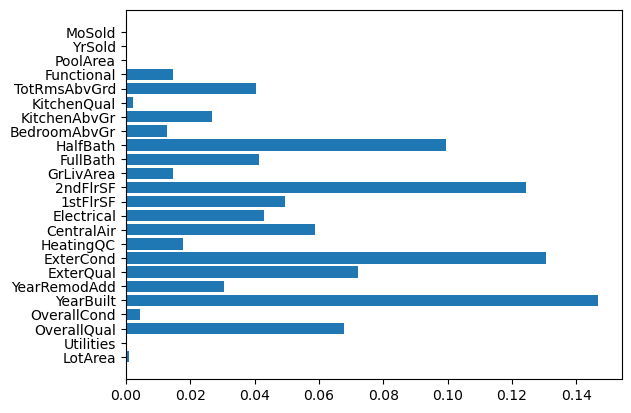

In [91]:
plt.barh(useful_fields,
        rf_model.feature_importances_)

In [92]:
from sklearn.inspection import permutation_importance

p_importances = permutation_importance(rf_model, X_test, y_test, n_repeats=10, n_jobs=-1)

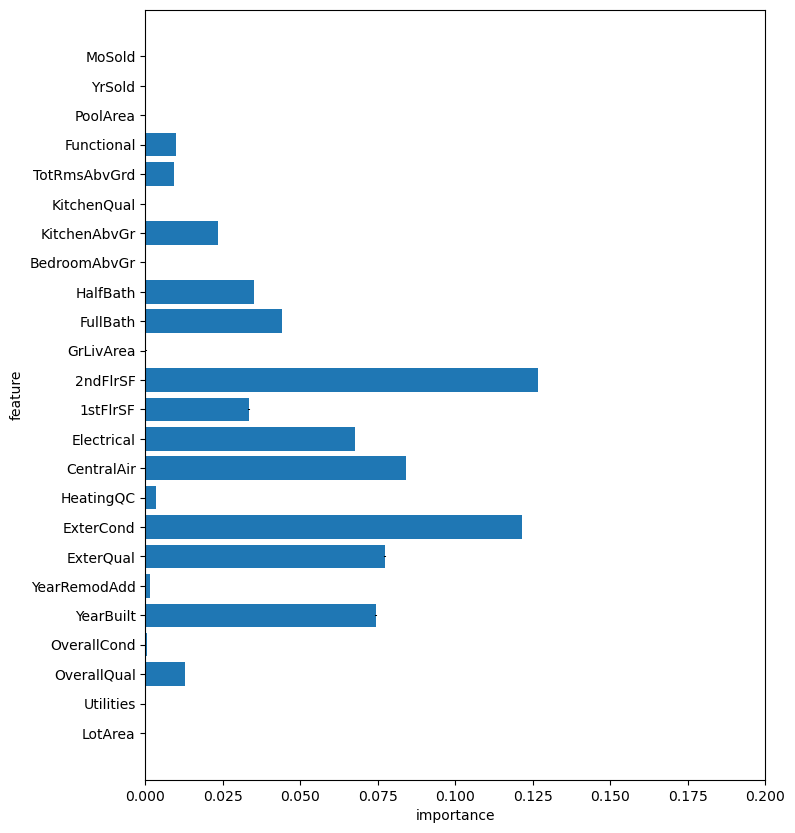

In [97]:
plot_importances(useful_fields, p_importances)

In [101]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fit your RandomForest model (assuming it's already done)
# rf_model.fit(X_train, y_train)

# Step 2: Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Step 3: Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)


In [105]:
print(X_test.shape, shap_values.shape)

(550, 24) (550, 24, 13)


In [102]:
shap_values.shape

(550, 24, 13)

In [128]:
# Step 4: Calculate the mean and variance of SHAP values for each class (cluster)
shap_means = {}
shap_stds = {}

for cluster in np.unique(y_test):  # Iterate through each cluster
    print(f'Doing cluster {cluster}')
    class_indices = np.where(y_test == cluster)[0]  # Get indices of samples in this class
 #   class_shap_values = [shap_values[i][class_indices] for i in range(len(shap_values))]  # SHAP values for this class

    class_shap_values = shap_values[class_indices][:,:,cluster]

    # Calculate the mean and variance of SHAP values for this class (across all features)
    mean_shap = np.mean(np.abs(class_shap_values), axis=0)
    std_shap = np.std(class_shap_values, axis=0)

    print(mean_shap.shape, std_shap.shape)
    shap_means[cluster] = mean_shap
    shap_stds[cluster] = std_shap


Doing cluster 0
(24,) (24,)
Doing cluster 1
(24,) (24,)
Doing cluster 2
(24,) (24,)
Doing cluster 3
(24,) (24,)
Doing cluster 4
(24,) (24,)
Doing cluster 5
(24,) (24,)
Doing cluster 6
(24,) (24,)
Doing cluster 7
(24,) (24,)
Doing cluster 8
(24,) (24,)
Doing cluster 9
(24,) (24,)
Doing cluster 10
(24,) (24,)
Doing cluster 11
(24,) (24,)
Doing cluster 12
(24,) (24,)


0 (24,) (24,)
1 (24,) (24,)
2 (24,) (24,)
3 (24,) (24,)
4 (24,) (24,)
5 (24,) (24,)
6 (24,) (24,)
7 (24,) (24,)
8 (24,) (24,)
9 (24,) (24,)
10 (24,) (24,)
11 (24,) (24,)
12 (24,) (24,)


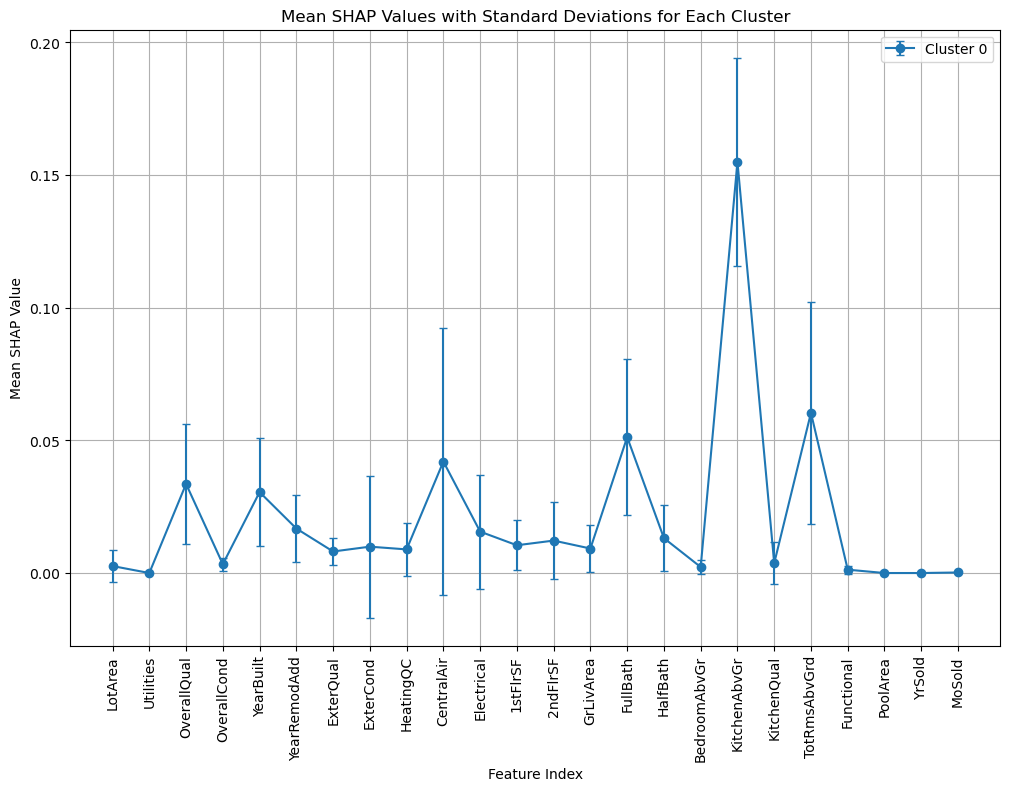

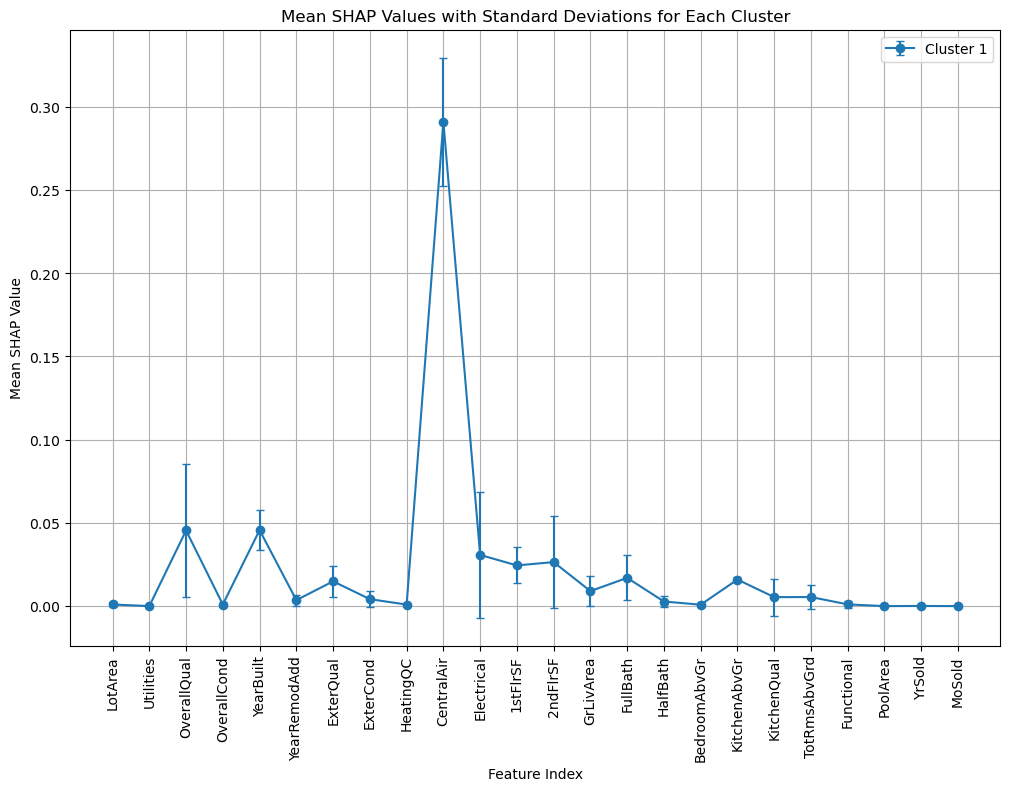

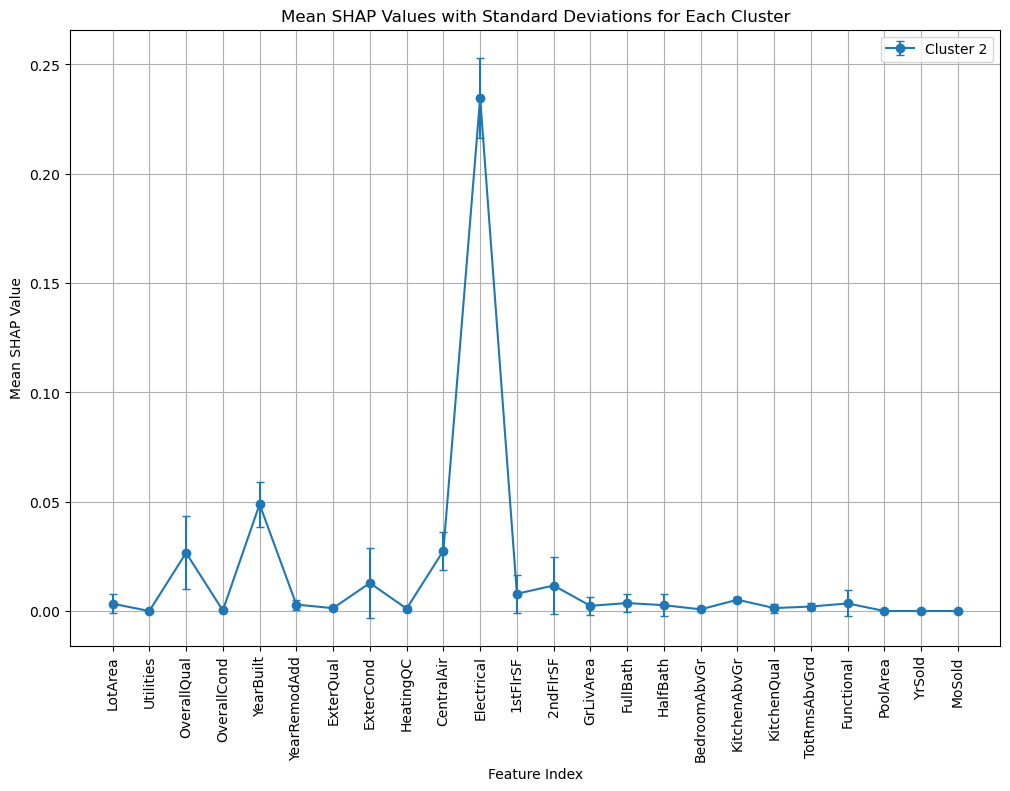

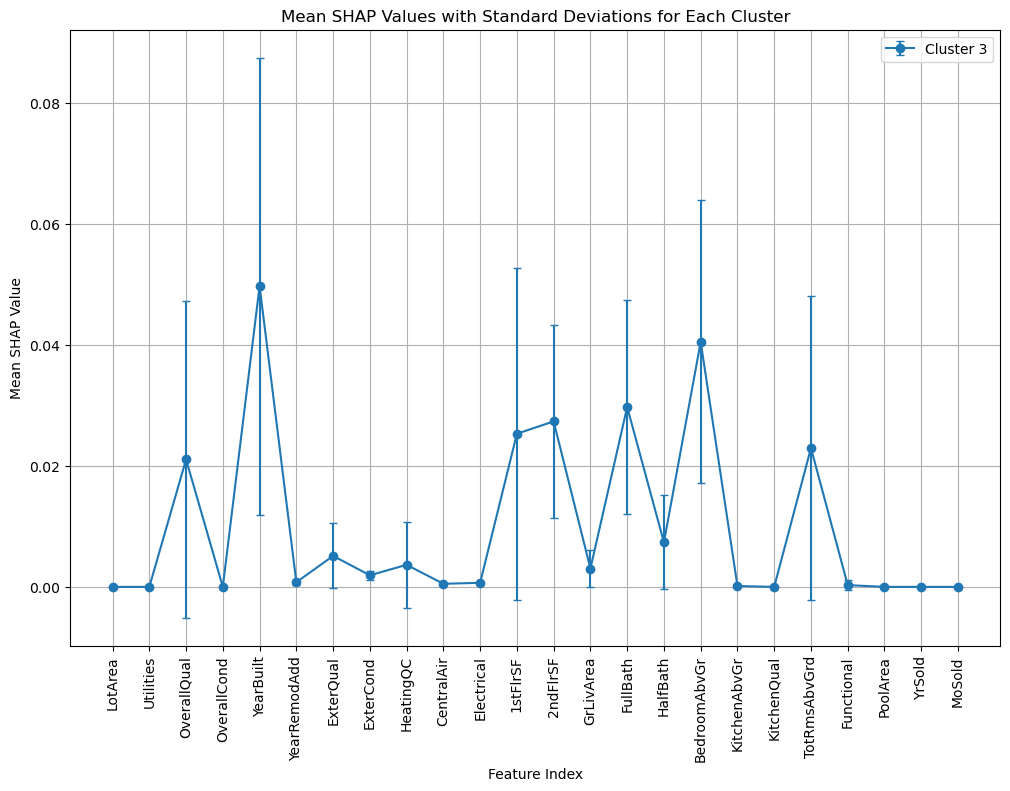

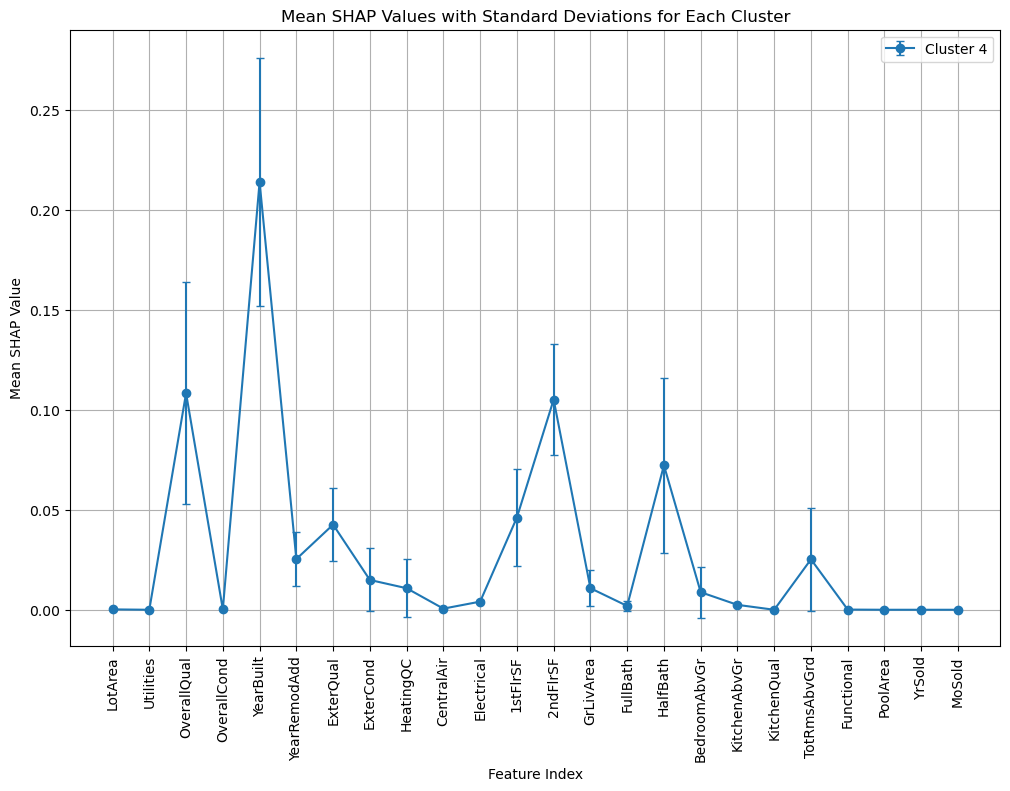

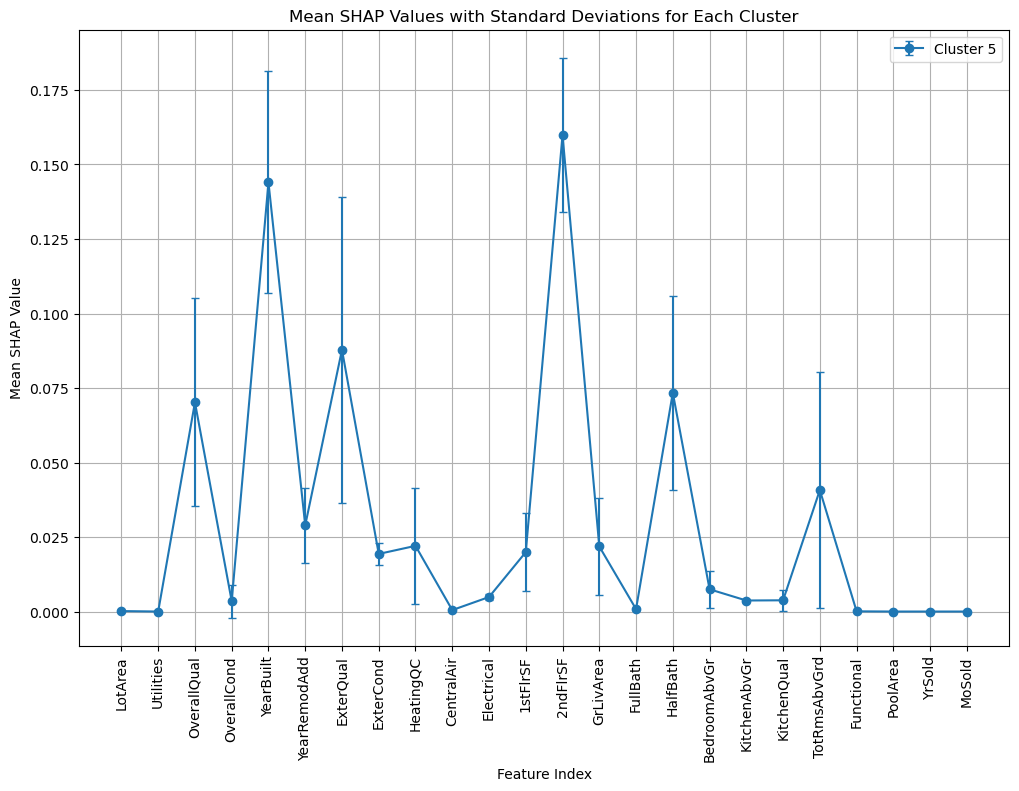

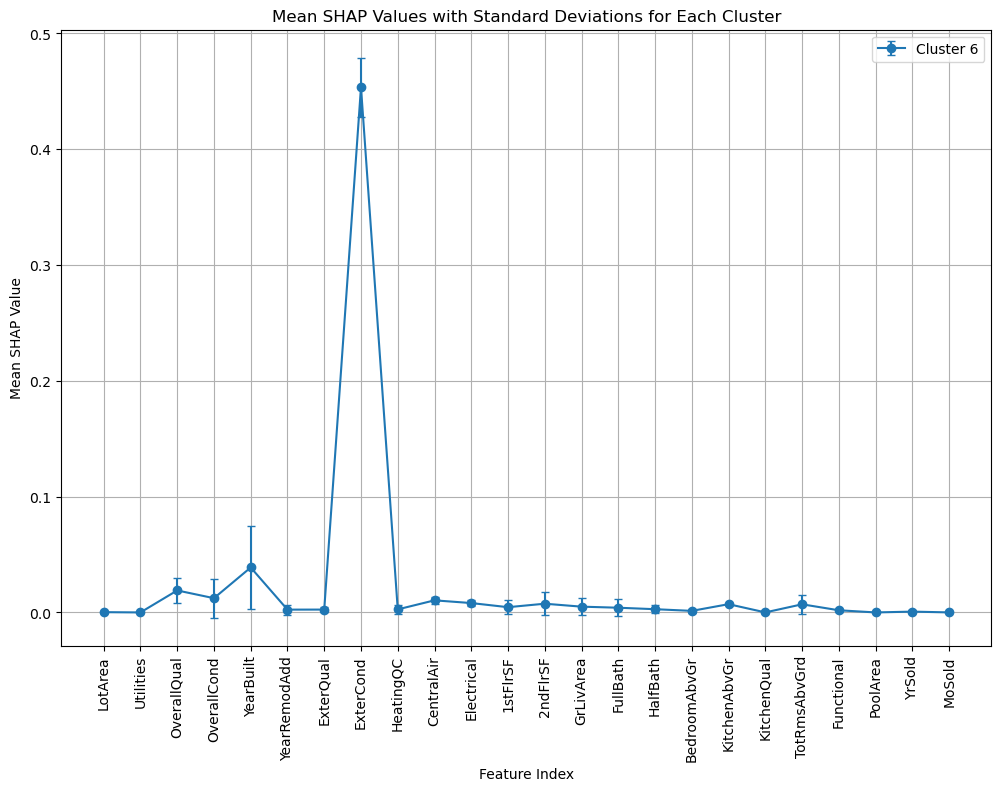

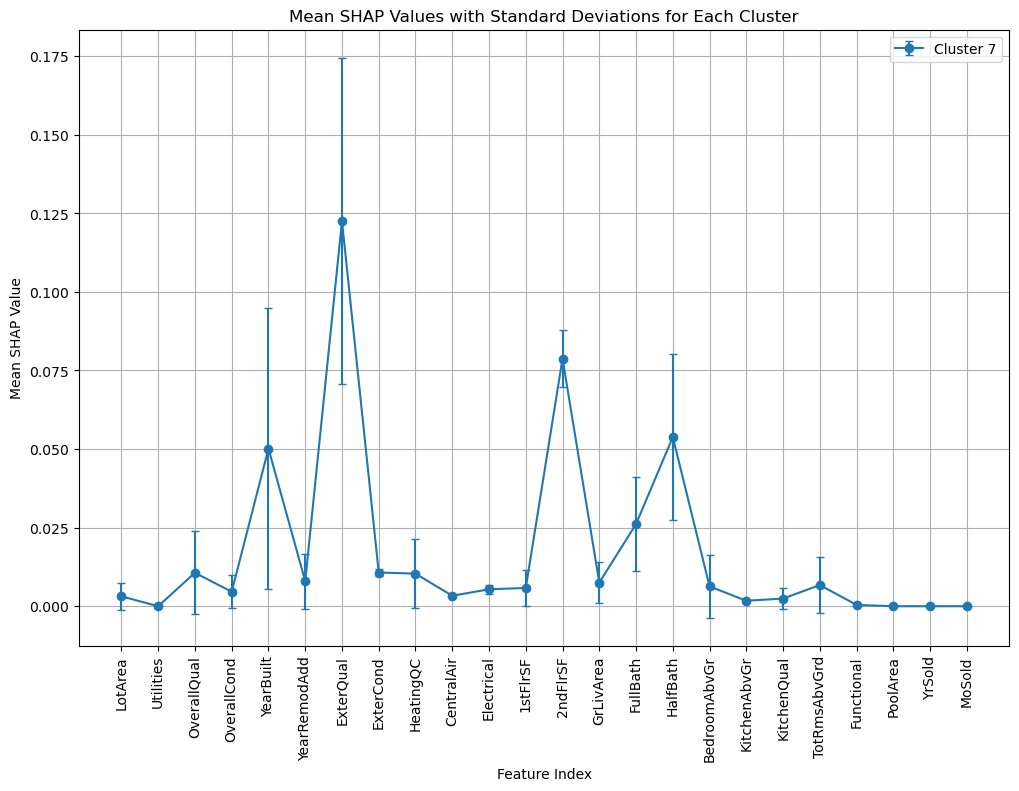

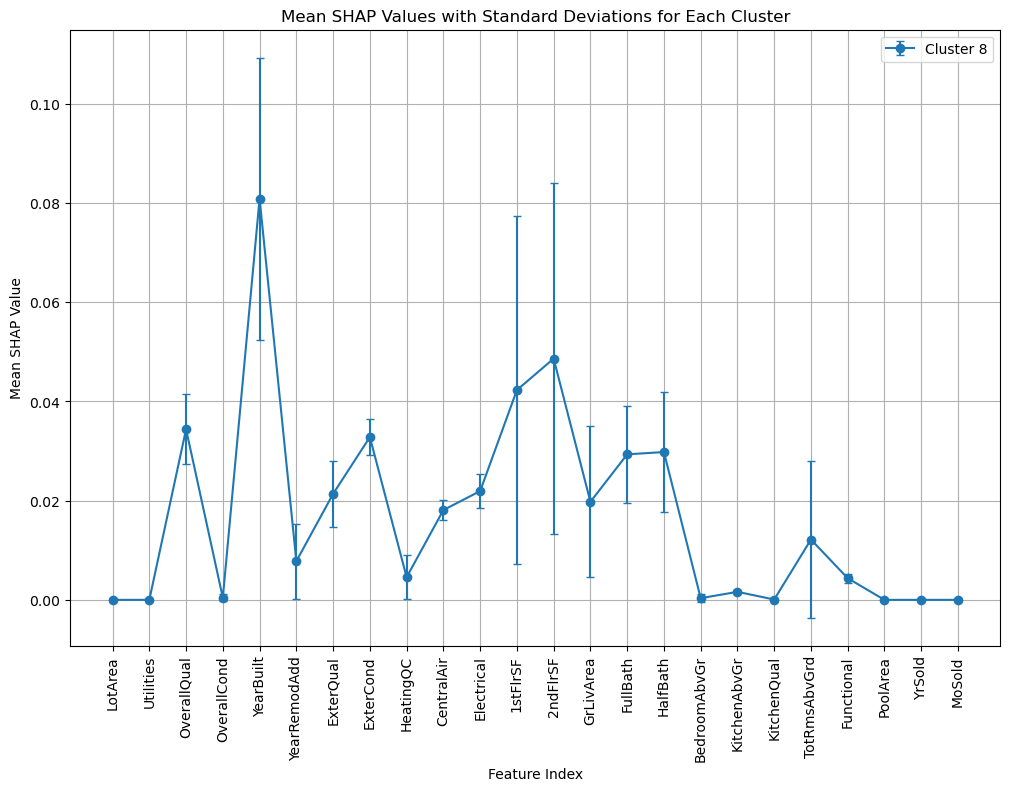

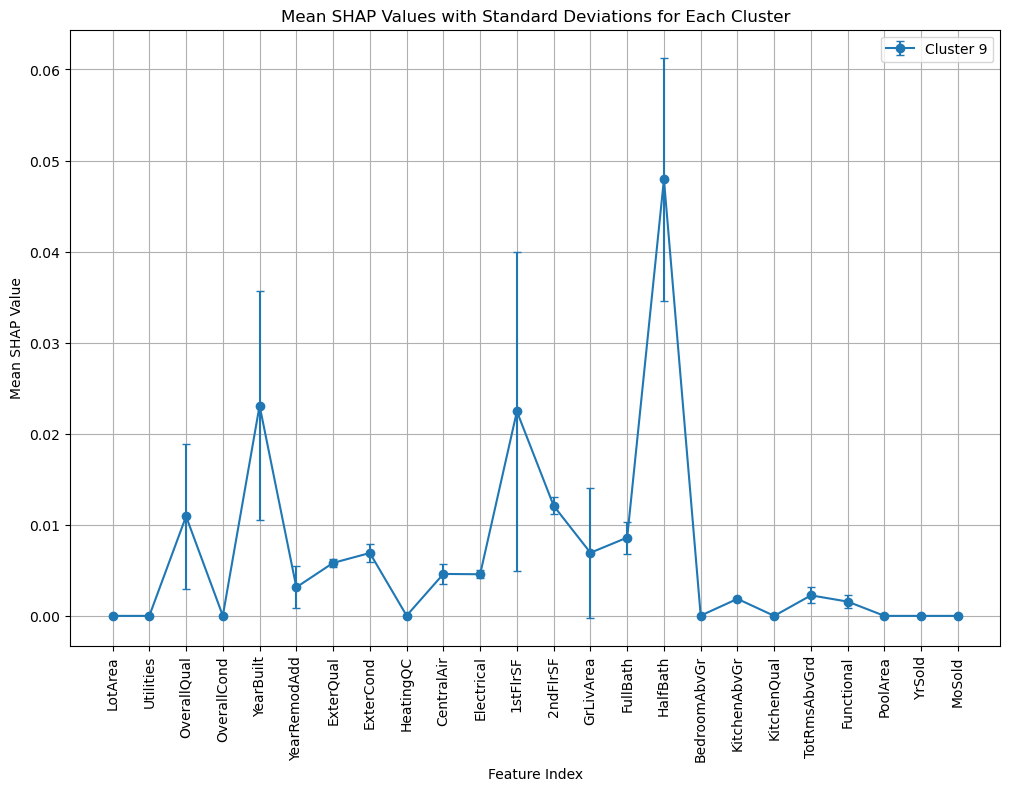

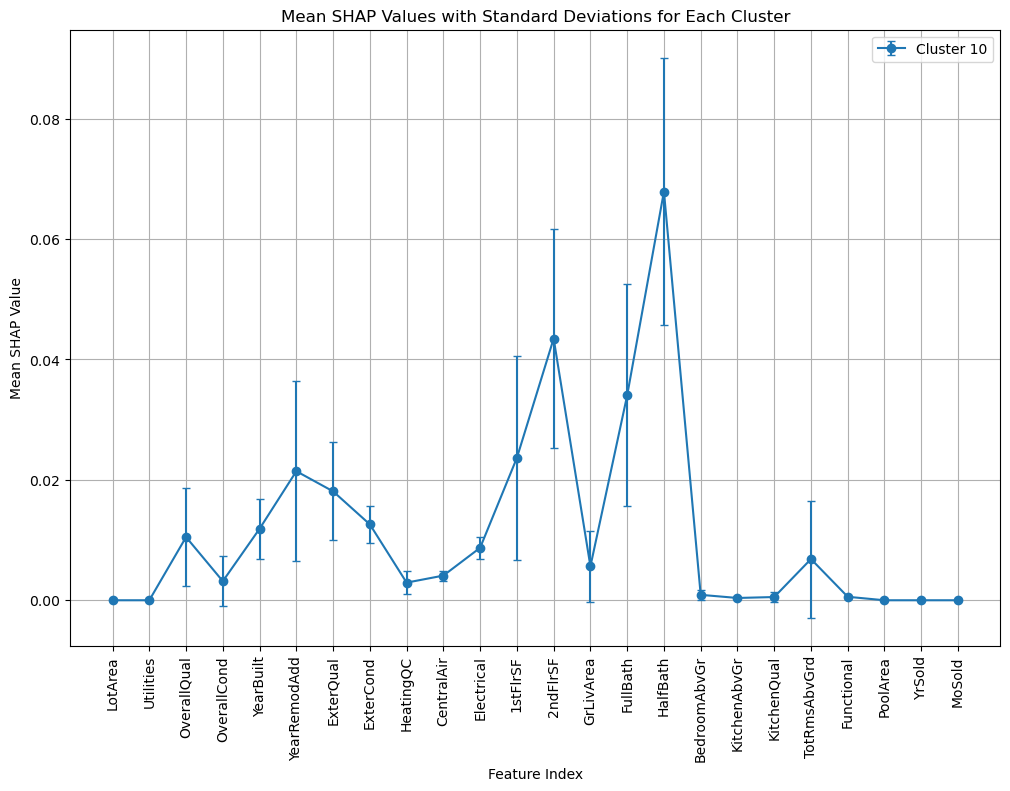

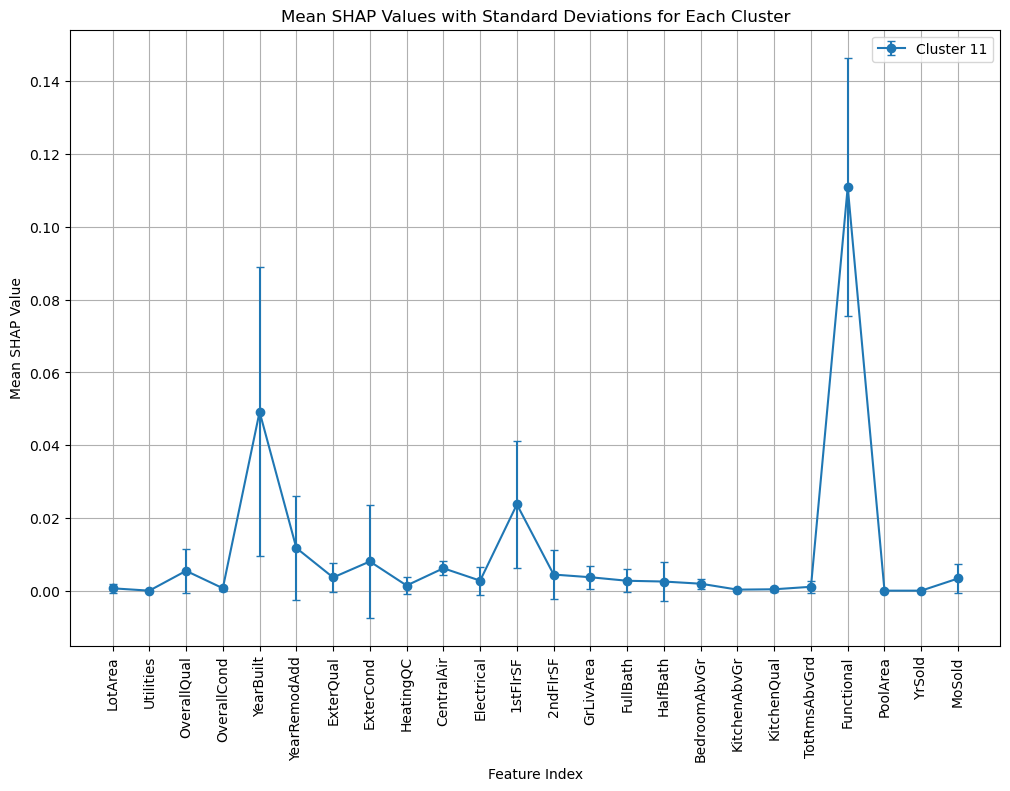

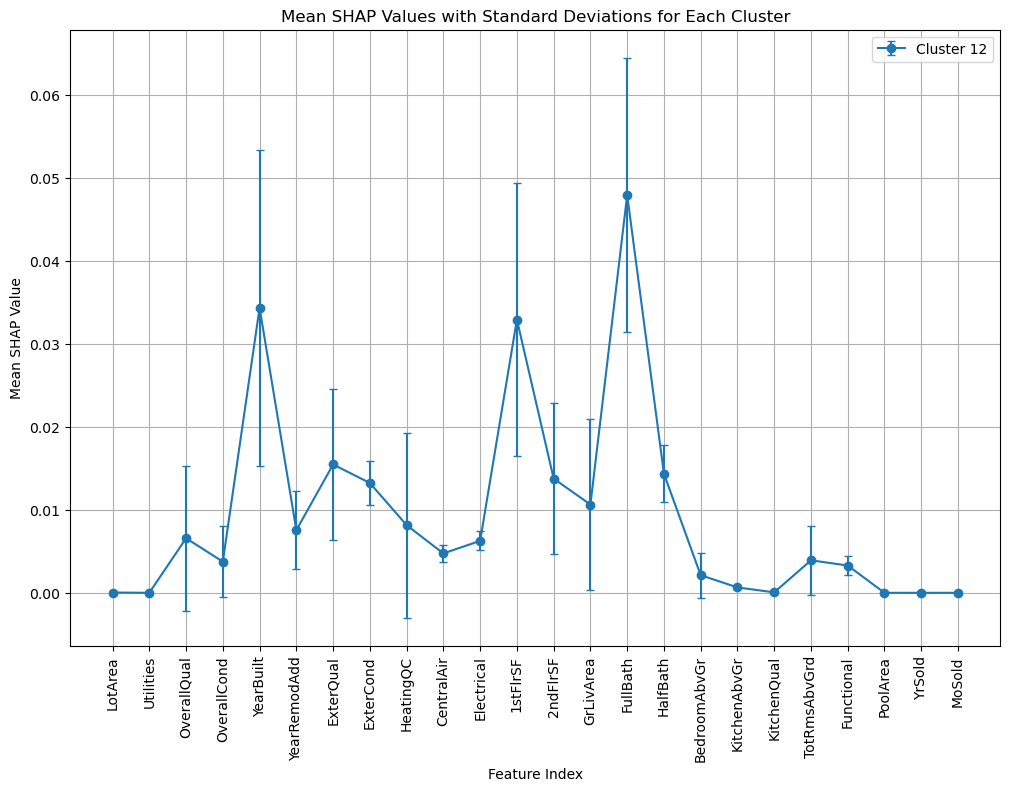

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Assume shap_means and shap_stds are dictionaries where keys are clusters (e.g., 0, 1, 2, ..., 12)
# and values are arrays of shape (num_features,), corresponding to mean and standard deviation of SHAP values

clusters = shap_means.keys()  # List of clusters
num_features = len(shap_means[0])  # Number of features (24 in this case)

# Create a figure for the plots

# Iterate over each cluster and plot the mean SHAP values with error bars
for cluster in clusters:
    plt.figure(figsize=(12, 8))
    means = shap_means[cluster]
    stds = shap_stds[cluster]
    
    print(cluster, means.shape, stds.shape)
    # Create an errorbar plot for each cluster
    plt.errorbar(
        range(num_features),  # X-axis: feature indices
        means,                # Y-axis: mean SHAP values for this cluster
        yerr=stds,            # Error bars: standard deviations of SHAP values for this cluster
        label=f'Cluster {cluster}',  # Label for each cluster
        capsize=3,            # Size of error bar caps
        marker='o',           # Style of points (circle markers)
        linestyle='-'         # Line connecting points
    )

    # Add labels, title, and legend
    plt.xlabel('Feature Index')
    plt.ylabel('Mean SHAP Value')
    plt.title('Mean SHAP Values with Standard Deviations for Each Cluster')
    plt.legend()
    plt.grid()
    plt.xticks(ticks=range(num_features), labels=useful_fields, rotation=90)



In [ ]:
classes=list(set(df_2['cluster']))
for column in df_2.columns:
    if column!='cluster':
        plt.figure(figsize=(19,5))
        plt.title(column)
        for cl in classes:
            arr=df_2[column][df_2['cluster']==cl]
            plt.hist(arr, density=True, alpha=0.5, bins=30)



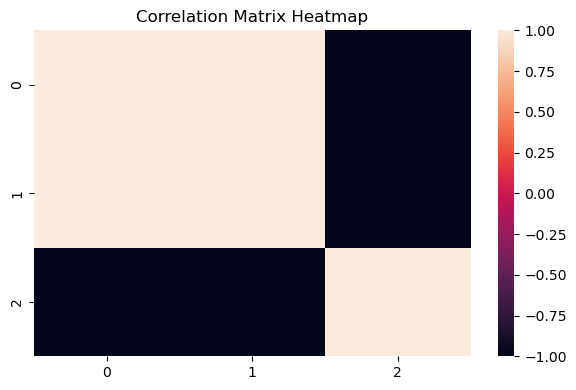

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data: each row is a variable, each column is an observation
data = np.array([
    [1, 2, 3, 4, 5],  # Variable 1
    [2, 4, 6, 8, 10], # Variable 2
    [5, 4, 3, 2, 1]   # Variable 3
])

# Compute the correlation matrix
corr_matrix = np.corrcoef(data)

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix)

# Show the plot
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()  # Adjusts the plot to fit the figure area
plt.show()

In [18]:
corr_matrix = np.corrcoef(data.transpose())

In [19]:
corr_matrix.shape

(24, 24)

<AxesSubplot: >

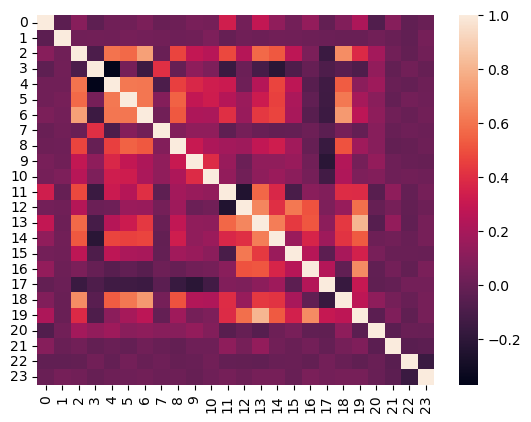

In [20]:
sns.heatmap(corr_matrix)

In [12]:
corr_matrix = np.corrcoef(data)


In [24]:
X.shape, y.shape

((178, 13), (178,))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


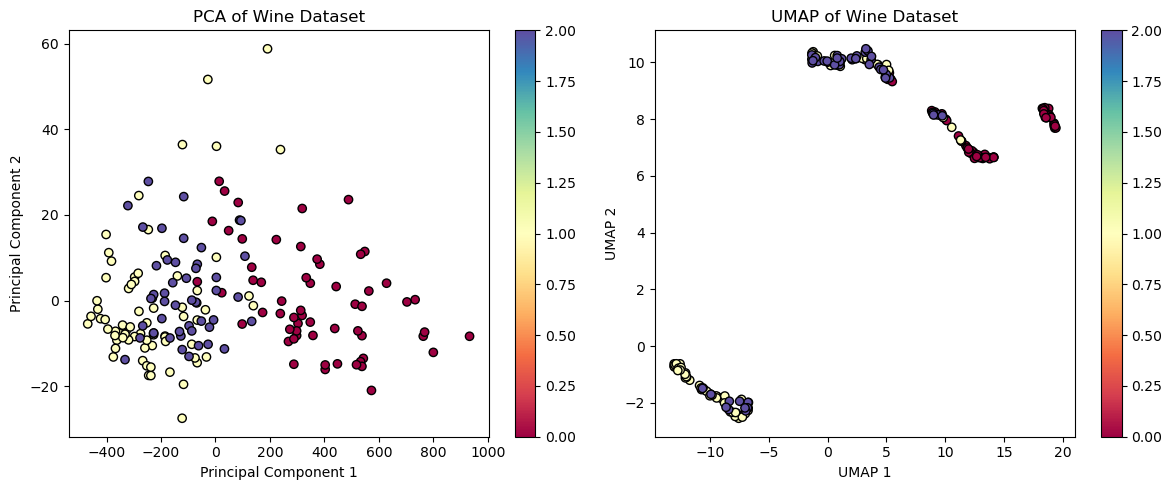

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
import umap

# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X)

# Plot PCA results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('PCA of Wine Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)

# Plot UMAP results
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('UMAP of Wine Dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap


# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
X_umap = umap_houses

# Plot PCA results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='k')
plt.title('PCA of AMES Dataset (Normalized)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot UMAP results
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], edgecolor='k')
plt.title('UMAP of AMES Dataset (Normalized)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

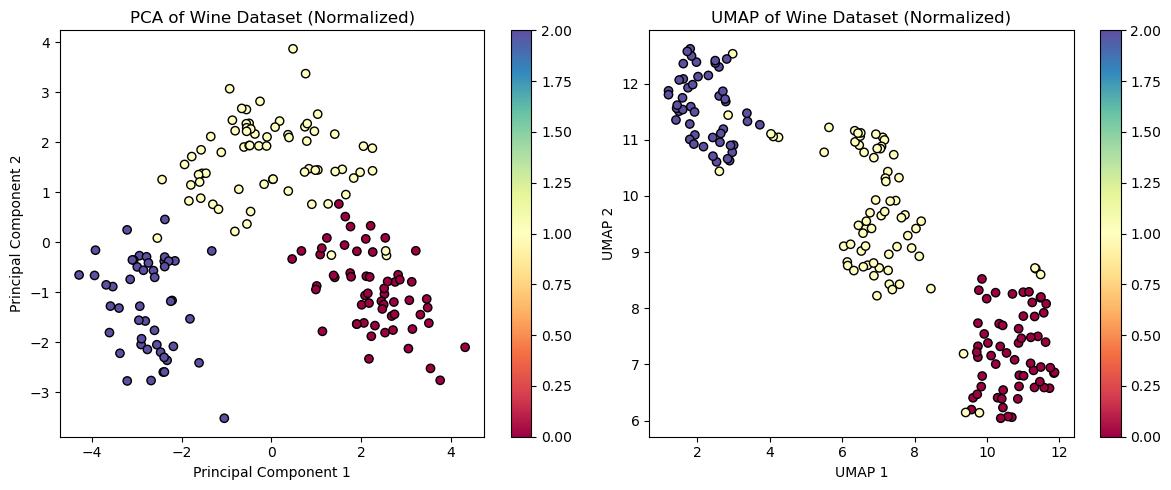

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# Plot PCA results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('PCA of Wine Dataset (Normalized)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(scatter)

# Plot UMAP results
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('UMAP of Wine Dataset (Normalized)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
#plt.colorbar(scatter)

plt.tight_layout()
plt.show()

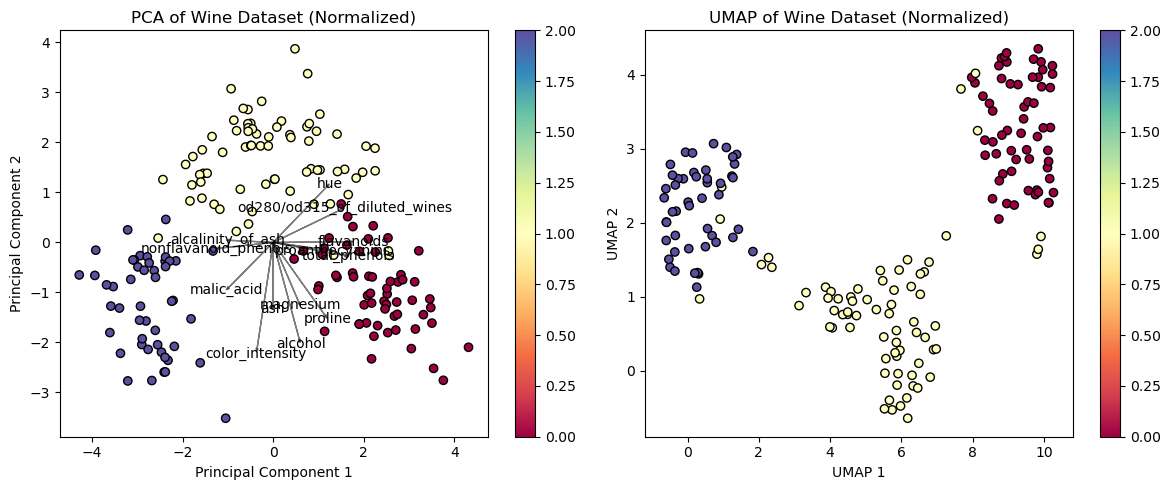

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# Plot PCA results with biplot
plt.figure(figsize=(12, 5))

# PCA Scatter Plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('PCA of Wine Dataset (Normalized)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)

# Biplot for PCA
for i in range(len(feature_names)):
    plt.arrow(0, 0, pca.components_[0, i]*4, pca.components_[1, i]*4,
              color='black', alpha=0.5, head_width=0.05)
    plt.text(pca.components_[0, i]*4.2, pca.components_[1, i]*4.2, feature_names[i],
             color='black', ha='center', va='center')

# Plot UMAP results
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('UMAP of Wine Dataset (Normalized)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()


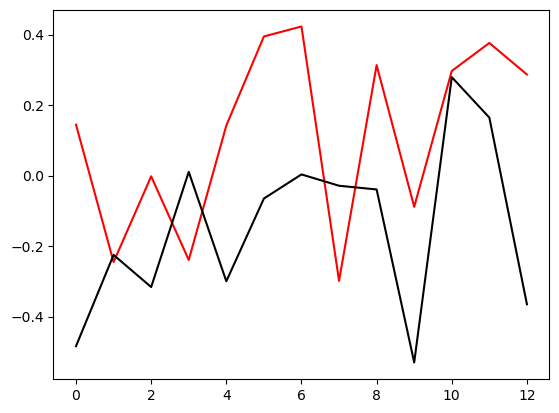

In [61]:
plt.plot(pca.components_[0,:], color='red')
plt.plot(pca.components_[1,:], color='black')

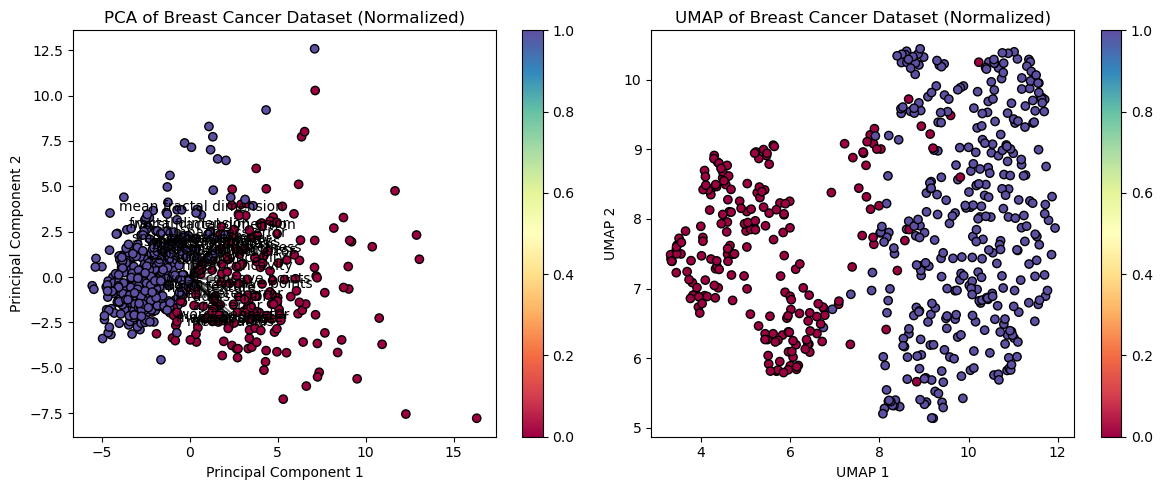

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# Load the Breast Cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# Plot PCA results with biplot
plt.figure(figsize=(12, 5))

# PCA Scatter Plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('PCA of Breast Cancer Dataset (Normalized)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)

# Biplot for PCA
for i in range(len(feature_names)):
    plt.arrow(0, 0, pca.components_[0, i]*10, pca.components_[1, i]*10,
              color='black', alpha=0.5, head_width=0.05)
    plt.text(pca.components_[0, i]*10.5, pca.components_[1, i]*10.5, feature_names[i],
             color='black', ha='center', va='center')

# Plot UMAP results
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Spectral', edgecolor='k')
plt.title('UMAP of Breast Cancer Dataset (Normalized)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

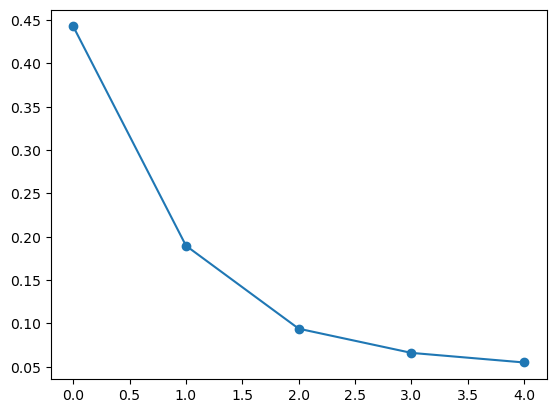

In [51]:
plt.plot(pca.explained_variance_ratio_,'-o')

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# Load the Breast Tissue dataset
# Ensure to provide the correct path to the CSV file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00458/breast_tissue.csv"
data = pd.read_csv(url)

# Preprocess the data
X = data.drop(columns=['Class'])  # Features
y = data['Class']  # Target classes

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# Plot PCA results
plt.figure(figsize=(12, 5))

# PCA Scatter Plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.astype('category').cat.codes, cmap='Spectral', edgecolor='k')
plt.title('PCA of Breast Tissue Dataset (Normalized)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)

# Plot UMAP results
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y.astype('category').cat.codes, cmap='Spectral', edgecolor='k')
plt.title('UMAP of Breast Tissue Dataset (Normalized)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()


HTTPError: HTTP Error 404: Not Found

In [56]:
pca.components_.shape

(5, 30)

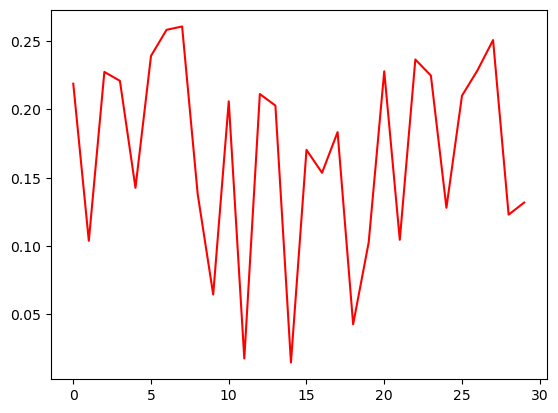

In [57]:
plt.plot(pca.components_[0,:], color='red')

In [31]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact, widgets
from sklearn.datasets import load_iris

# Example dataset (you can replace this with your actual dataset)
data = load_iris().data
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Convert data to a pandas DataFrame (for easier column selection)
df = pd.DataFrame(data, columns=column_names)

# UMAP transformation
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(df)

# Function to plot the scatter plot based on selected column
def plot_umap(column):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(umap_houses[:, 0], umap_houses[:, 1], c=df[column], cmap='viridis', s=20)
    plt.colorbar(scatter)
    plt.title(f'Scatter plot colored by {column}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

# Create a dropdown menu with the column names
dropdown = widgets.Dropdown(
    options=column_names,
    value=column_names[0],  # default value
    description='Color by:',
)

# Use interact to link the dropdown with the plotting function
interact(plot_umap, column=dropdown)

/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



interactive(children=(Dropdown(description='Color by:', options=('sepal_length', 'sepal_width', 'petal_length'…

<function __main__.plot_umap(column)>

**Message:** Visualization techniques are useful for having an initial grasp of multi-dimensional datasets and guide further analysis and the choice of the modelling data strategy.

**Caveats:**
- available t-SNE implementations may vary a lot in terms of performance. Computational time can be reduced performing PCA before a t-SNE projection

- UMAP, thanks to the algorithm being amanable to clever initializations and optimization schemes, offers great stability and scaling properties

- UMAP, even if starting from a local picture, is generally more able to spread apart different clusters

- The result of an embedding may depend on the values of the metaparameters. One should try to see how the final embedding changes in order to get to a complete picture